# Goals
- Set up a pipeline using the Pipeline object from sklearn.pipeline.
- Perform a grid search for the best parameters using GridSearchCV() from sklearn.model_selection
- Analyze the results from the GridSearchCV() and visualize them

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV

# The Dataset

We’ll use the Ecoli Dataset from the UCI Machine Learning Repository

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/ecoli/ecoli.data',
                sep = '\s+',
                header=None)
df.head()

,0,1,2,3,4,5,6,7,8
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


We’ll ignore the first column, which specifies the sequence name. The last column is the class label. Let’s separate the features from the class label and split the dataset into 2/3 training instances and 1/3 test examples.

In [4]:
# The data matrix X
X = df.iloc[:, 1:-1]
# The labels Y
Y = df.iloc[:, -1:]
print(X.head())
print(Y.head())

      1     2     3    4     5     6     7
0  0.49  0.29  0.48  0.5  0.56  0.24  0.35
1  0.07  0.40  0.48  0.5  0.54  0.35  0.44
2  0.56  0.40  0.48  0.5  0.49  0.37  0.46
3  0.59  0.49  0.48  0.5  0.52  0.45  0.36
4  0.23  0.32  0.48  0.5  0.55  0.25  0.35
    8
0  cp
1  cp
2  cp
3  cp
4  cp


In [5]:
# Encode labels into unique integers
encoder = LabelEncoder()
y = encoder.fit_transform(np.ravel(Y))

The method expects a 1-D array, while our original Y was a column.

Therefore we need to transform it to 1-D array -> Using numpy.ravel

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (224, 7)
X_test shape: (112, 7)


For this tutorial, we have chosen the k-nearest neighbor classifier to perform the classification of this dataset.

# A Classifier Without a Pipeline and Optimization

In [7]:
knn = KNeighborsClassifier().fit(X_train, y_train)
print('Training set score:', knn.score(X_train, y_train))
print('Test set score:', knn.score(X_test, y_test))

Training set score: 0.9017857142857143
Test set score: 0.8482142857142857


We should keep in mind that the true judge of a classifier’s performance is the test set score and not the training set score. The test set score reflects the generalization ability of a classifier.

# Setting Up a Machine Learning Pipeline

For this tutorial, we’ll set up a very basic pipeline that consists of the following sequence:

1. Scaler: For pre-processing data, i.e., transform the data to zero mean and unit variance using the StandardScaler().
2. Feature selector: Use VarianceThreshold() for discarding features whose variance is less than a certain defined threshold.
3. Classifier: KNeighborsClassifier(), which implements the k-nearest neighbor classifier and selects the class of the majority k points, which are closest to the test example.

In [8]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold()),
    ('classifier', KNeighborsClassifier())
])

The pipe object is simple to understand. It says, scale first, select features second and classify in the end. Let’s call fit() method of the pipe object on our training data and get the training and test scores.

In [9]:
pipe.fit(X_train, y_train)
print('Training set score:', pipe.score(X_train, y_train))
print('Test set score:', pipe.score(X_test, y_test))

Training set score: 0.8794642857142857
Test set score: 0.8392857142857143


So it looks like the performance of this pipeline is worse than the single classifier performance on raw data. Not only did we add extra processing, but it was all in vain. Don’t despair, the real benefit of the pipeline comes from its tuning. The next section explains how to do that.

# Optimizating and Tuning the Pipeline

In the code below, we’ll show the following:

1. We can search for the best scalers. Instead of just the StandardScaler(), we can try MinMaxScaler(), Normalizer() and MaxAbsScaler().
2. We can search for the best variance threshold to use in the selector, i.e., VarianceThreshold().
3. We can search for the best value of k for the KNeighborsClassifier().

The parameters variable below is a dictionary that specifies the key:value pairs. Note the key must be written, with a double underscore __ separating the module name that we selected in the Pipeline() and its parameter. Note the following:

1. The scaler has no double underscore, as we have specified a list of objects there.

2. We would search for the best threshold for the selector, i.e., VarianceThreshold(). Hence we have specified a list of values \[0, 0.0001, 0.001, 0.5\] to choose from.

3. Different values are specified for the n_neighbors, p and leaf_size parameters of the KNeighborsClassifier().

In [10]:
parameters = {
    'scaler': [StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler()],
    'selector__threshold': [0, 0.001, 0.01, 0.5],
    'classifier__n_neighbors': [1,3,5,7,10],
    'classifier__p': [1,2],
    'classifier__leaf_size': [1,5,10,15]
}

The pipe along with the above list of parameters are then passed to a GridSearchCV() object, that searches the parameters space for the best set of parameters as shown below:

In [11]:
grid = GridSearchCV(pipe, parameters, cv=2).fit(X_train, y_train)
print('Training set score:', grid.score(X_train, y_train))
print('Test set score:', grid.score(X_test, y_test))

D:\Adminned\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File 

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

Training set score: 0.8928571428571429
Test set score: 0.8571428571428571


D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Adminned\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\Adminned\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "D:\Adminned\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "D:\Adminned\lib\site-packages\sklearn\base.py", line 702, in fit_transform
  

We yield the results:
- Training set score: 0.8928571428571429
- Test set score: 0.8571428571428571

By tuning the pipeline, we achieved quite an improvement over a simple classifier and a non-optimized pipeline. It is important to analyze the results of the optimization process.

Don’t worry too much about the warning that you get by running the code above. It is generated because we have very few training samples and the cross-validation object does not have enough samples for a class for one of its folds.

In [12]:
# Access the best set of parameters
best_params = grid.best_params_
print(best_params)
# Stores the optimum model in the best_pipe
best_pipe = grid.best_estimator_
print(best_pipe)

{'classifier__leaf_size': 1, 'classifier__n_neighbors': 7, 'classifier__p': 2, 'scaler': StandardScaler(), 'selector__threshold': 0}
Pipeline(steps=[('scaler', StandardScaler()),
                ('selector', VarianceThreshold(threshold=0)),
                ('classifier',
                 KNeighborsClassifier(leaf_size=1, n_neighbors=7))])


In [16]:
results_df = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')
print(results_df)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.008975      0.000008         0.012466        0.000504   
1         0.005466      0.001514         0.005505        0.000479   
2         0.003465      0.000513         0.004015        0.000015   
3         0.003492      0.000499         0.003989        0.000001   
4         0.003493      0.000524         0.005480        0.000509   
..             ...           ...              ...             ...   
635       0.002994      0.000001         0.000000        0.000000   
636       0.003491      0.000498         0.004488        0.000499   
637       0.002493      0.000498         0.004489        0.000500   
638       0.002493      0.000499         0.004488        0.000499   
639       0.002489      0.000502         0.000000        0.000000   

    param_classifier__leaf_size param_classifier__n_neighbors  \
0                             1                             1   
1                             1          

This DataFrame is very valuable as it shows us the scores for different parameters. The column with the mean_test_score is the average of the scores on the test set for all the folds during cross-validation. The DataFrame may be too big to visualize manually, hence, it is always a good idea to plot the results. 

Let’s see how n_neighbors affect the performance for different scalers and for different values of p.

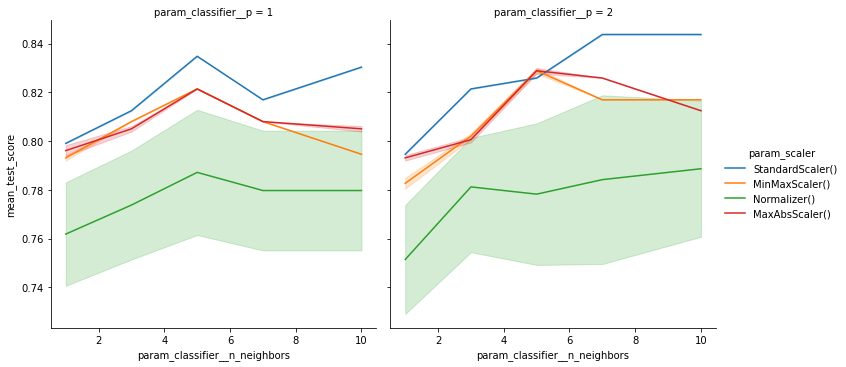

In [17]:
sns.relplot(data=results_df, kind='line', x='param_classifier__n_neighbors',
           y='mean_test_score', hue='param_scaler', col='param_classifier__p')
plt.show()

The plot clearly shows that using p=2, n_neighbors=7, and StandardScaler() yields the best result.

Let's make one more set of plots with leaf_size

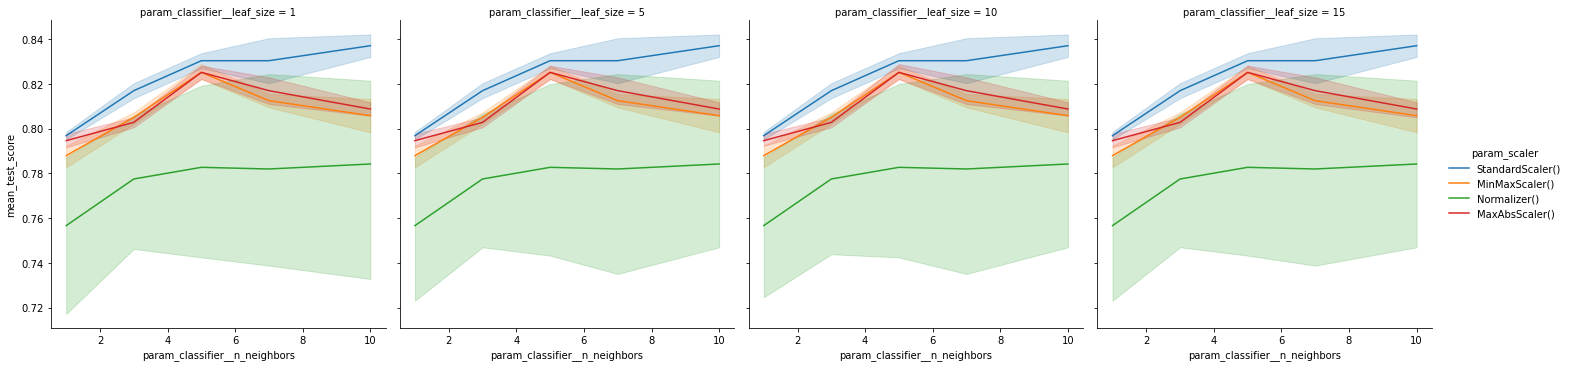

In [19]:
sns.relplot(data=results_df,
            kind='line',
           x="param_classifier__n_neighbors",
           y='mean_test_score',
           hue='param_scaler',
           col='param_classifier__leaf_size')
plt.show()

The dataset used for this tutorial is quite small with a few example points but still the results are better than a simple classifier.

# In this tutorial we learned the following:

- How to build a machine learning pipeline.
- How to optimize the pipeline using GridSearchCV.
- How to analyze and compare the results attained by using different sets of parameters.
[Tutorial link](https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/)